In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_noint = pd.read_csv("../results/exp_1_no_clean_no_int_10k.csv")

In [3]:
df_yesint = pd.read_csv("../results/exp_2_no_clean_yes_int_10k.csv")

In [5]:
df_noint["score"].sum()

632483

In [6]:
df_yesint["score"].sum()

632483

### As we see, for this small sample of 10K it did not make a difference to include the international dictionary. This makes sense as the international drugs are (1) not always captured by the EU drug list, which is the only one we have at the moment, and (2) this sample is likely too small to assume that a popular EU drug was even included in this test.
### Currently, we are using fuzzy matching for the detection of EU drug list entries. However, this makes the process approximately 5x slower per iteration, which makes this intractable for the entire 500k+ entry data set of FAERS (It takes about 1 hour to do 10K for example on my machine). For this reason, we must either choose to do direct matching for international drugs or exclude it entirely.

In [2]:
dev_df = pd.read_csv("../data/FAERS_DEV_SET.csv")

In [19]:
dev_set_distribution: pd.Series = dev_df["origin"].value_counts()

In [26]:
dev_set_distribution = dev_set_distribution.sort_index()

In [40]:
first = dev_set_distribution.values[-1]

In [42]:
rest = list(dev_set_distribution.values[:-1])

In [44]:
sorted_dataset_dist_vals = [first] + rest

In [46]:
d = {}
for i, v in enumerate(sorted_dataset_dist_vals):
    d[i] = v

In [49]:
first_k = dev_set_distribution.keys()[-1]
rest_k = dev_set_distribution.keys()[:-1]
rest_k = list(rest_k.values)
sorted_dataset_dist_keys = [first_k] + rest_k

dd = {}
for k,v in zip(sorted_dataset_dist_keys, sorted_dataset_dist_vals):
    dd[k] = v

# Dev dataset balance
### For some reason the dataset, created by randomly sampling the full FAERS set and extracting 50K samples, does not contain a single entry of 2018Q1 and 2018Q2 data. The rest of the data set is quite balanced, albeit a bit skewed towards the more recent years. This is expected, as each year the amount of data added to FAERS seems to be increasing, resulting in a bias towards newer entries.
### The data in the plot starts at 2012Q4, and every color alternation depicts a different year.

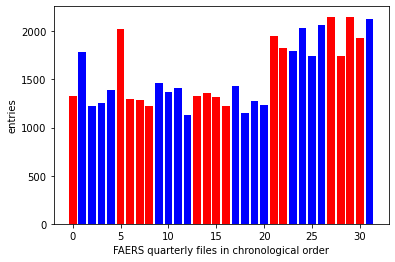

In [79]:
years = ["12", "14", "16", "18", "20"]
clrs = ['red' if (any(year in x for year in years)) else 'blue' for x in sorted_dataset_dist_keys ]
plt.bar(range(len(d)), list(d.values()), align='center', color=clrs)
plt.ylabel("entries")
plt.xlabel("FAERS quarterly files in chronological order")
plt.show()

### Looking at the result of our run on the test set without any preprocessing and no international dictionary, we see that firstly, the NDA matches are not present whatsoever. This is kind of expected of a run with only a subset of entries, as NDA numbers are rarely included in the submission and on top of that, some of the NDA numbers are not even entered correctly and contain bogus values instead (e.g. 999999)

### Furthermore, we see that drug name only by far resulted in the best matches out of the available query options. However, one must be aware that quite frequently, the drugname entry actually contains more information than just the trade name for example, there are entries that include the route of administration + the dosage information, which is actually quite useful already for RxNav matches.

### Lastly, it is of note that the Default Query option was less useful than the Backup Query, which suggests that when a high-quality entry in product active ingredient is present, this is more helpful in matching against RxNav

In [3]:
df_full_noint = pd.read_csv("../results/exp_3_no_clean_no_int_fulldev.csv")
df_full_noint["method"].value_counts()

DNO    35307
BUQ     9964
DFQ     3884
NIL      845
Name: method, dtype: int64

In [4]:
# split data into brackets
no_match = df_full_noint[df_full_noint["score"] == 0]
below_25 = df_full_noint[df_full_noint["score"].between(1, 24)]
btw_25_50 = df_full_noint[df_full_noint["score"].between(25, 49)]
btw_50_80 = df_full_noint[df_full_noint["score"].between(50, 79)]
eq_or_above_80 = df_full_noint[df_full_noint["score"] >= 80]

# Group 0: No Match
### When looking into what kind of queries received absolutely no match, it seems that none of the approaches returned any kind of match at all, as the query for all NIL results are also empty.

### Looking into the drugnames of the full dev dataset at all the indices where we got NIL results, we see that most of the entries are either:
- non-descriptive ("MG SALT", "MUTLIVITAMINS", "UNSPECIFIED DEPRESSION PILL")
- foreign ("SHUMAITONG", "HERBESSER", Trade name for Diltiazem in asian countries)
- misspelled in ambiguous ways ("NEOTIGISAN" should probably be "NEOTIGASON")
- nonsensical ("30 PILLS")
- and abbreviations ("TZD", "XYZL")

### Looking at the percent of prod_ai actually available for backup queries, it seems that 98.6% of the NIL matches have no prod_ai data, which means that the data quality for these NIL matches is in line with expectations of entries that are hard to match also being those that were submitted with less data or less carefully.

In [97]:
no_match["query"].isna().sum() == len(no_match) 

True

In [105]:
no_match_full = dev_df.iloc[no_match.index]

In [108]:
list(no_match_full["drugname"])

['B-72',
 'BETABLOCK',
 'NEOTIGISAN',
 'BENAPHEN PLUS',
 'MULTVITAMINS',
 'Levothyroxinelevothyroxine',
 'NEPHROTOXINE',
 'Beviplex',
 'CODEINPHOSPHAT',
 'VEROSPILACTONE',
 'BERES DROPS',
 'TACHIPIRINA 500MG',
 'N-DESMETHYLVENLAFAXINE',
 "Galen's cerate",
 'MVI 50+',
 'JUICEPLUS',
 'METICORTELONE',
 'BALDRIANWURZEL HLP',
 'CODACAMOL',
 'TAXA',
 'AREDS ANIT-OXIDANTS',
 'Ondansan',
 'BEAUCY ',
 'KDER',
 'Sedistress',
 'AMIPRILOSE HYDROCHLORIDE',
 'Cephelosporins',
 'ZEDD',
 'medathoroxin',
 'GLUTACORTISONE',
 'Paracodin N Tropfen',
 'Baldorat',
 'INJECTION B12',
 'MG SALT',
 'Multiviatmin',
 'GOBIODIA',
 'MULTIVITAMON',
 'VTIM B',
 'Mcg',
 'MUCOSYTE',
 'PANKREATICUM Hev B Verdau',
 'SNET',
 'levalbuterol 45mcg',
 'Tetrolex',
 'BMS?986310.',
 'Magnelis b6 forte',
 'ACETYLSALICYLICSAEURE',
 'TIBIAL',
 'RINOVANEDIF',
 'ACTIVEX 40 PLUS',
 'TOBIPODHAER',
 'MWSH',
 'ZOFRAMOMEPRAZOLE',
 'SNRIS',
 'Methacarbonal',
 'AVORSTANTIN',
 'NKDA',
 'UROFLUS',
 'ECXILUNTCH',
 'NOSELVIST',
 'ELBUS',
 'ALTR

In [111]:
no_match_full["prod_ai"].isna().sum() / len(no_match_full) * 100  # percent of NaN entries in the NIL matches.

98.57988165680473

In [138]:
origin_counts = no_match_full["origin"].value_counts()

In [140]:
origin_counts.sort_index(inplace=True)

In [147]:
no_match_sorted_vals = [origin_counts[-1]] + list(origin_counts[:-1].values)  # this hack is necessary to properly order 12q4 as first

In [154]:
no_match_contribution = [(x/y) for x, y in zip(no_match_sorted_vals, sorted_dataset_dist_vals)]

# The plot below shows the normalized contribution of each quarter's data to the no matchers
- NOTE: it's normalized by dividing each no_matcher of a specific origin by the amount of it present in the dev set

Text(0.5, 0, 'FAERS quarterly files in chronological order')

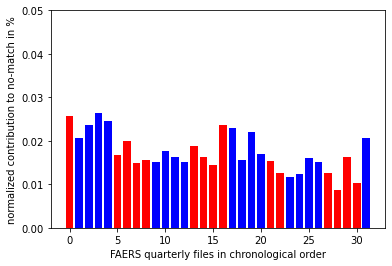

In [168]:
plt.bar(range(len(no_match_contribution)), no_match_contribution, align='center', color=clrs)
plt.ylim([0, 0.05])
plt.ylabel("normalized contribution to no-match in %")
plt.xlabel("FAERS quarterly files in chronological order")
# plt.show()

In [ ]:
# def setup_brackets(path: str):
#     df = pd.read_csv("../results/exp_3_no_clean_no_int_fulldev.csv")
#     df["method"].value_counts()

In [169]:
plt.savefig("../results/no_match_contrib_no_clean_no_int_fulldev.png")

<Figure size 432x288 with 0 Axes>

# Next we will be looking at the second group, every match that returned a score above 0 but < 25. This will be matches that somewhat resemble entries in RxNorm.

### Looking at which query types were most successful here, we see that it's drug name only, however since drug name only queries are the most successful ones across the entire data set, this is to be expected. If we account for the ratios on the entire data set:
- DNO: 70.6%
- BUQ: 19.9%
- DFQ: 7.7%
- NIL: 1.7%

### in the below 25 section, DNO accounts for 76.7%, which is even more than over the entire data set.

In [7]:
below_25 = below_25[below_25["score"] != 0] # Correction for including 0 scores, whoops

In [9]:
below_25["method"].value_counts()

DNO    848
BUQ    132
DFQ    125
Name: method, dtype: int64

In [15]:
below_25_full = dev_df.iloc[below_25.index]

### Now we look at the full data set, to see what the general quality of the entries is for this group < 25. The first thing I notice is the sparsity of data in the columns, there are a lot of NaN values. This is in line with expectations as I expect the data to be harder to match to also be data that is of lesser quality in terms of how carefully and completely the data was submitted.

### Furthermore, I also notice that the drug name entries are often noisier such as "PHYSIOTENS 0,4 mg, comprim? pellicul?". It could be that the question marks are just characters that got corrupted from UTF, as the FAERS db only supports ASCII. We also see one prevalent error that appears more often, I will call them "stray digits" henceforth --> "ORADEXON /00016001/". These numbers after the entries seem to have a negative impact on the matching as they are probably not cleaned by the RxNav algorithm.

In [17]:
below_25_full.sample(frac=0.1)

,primaryid,caseid,drug_seq,role_cod,drugname,val_vbm,route,dose_vbm,cum_dose_chr,cum_dose_unit,...,lot_nbr,exp_dt,nda_num,dose_amt,dose_unit,dose_form,dose_freq,origin,lot_num,prod_ai
37859,105839151,10583915,3,C,CALCIO LEVOFOLINATO TEVA - 25 MG POLVERE PER S...,2,NaN,POWDER FOR SOLUTION FOR INJECTION,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,SOLUTION FOR INJECTION,NaN,DRUG14Q4.txt,NaN,NaN
48460,128766112,12876611,4,C,ORADEXON /00016001/,2,Intravenous (not otherwise specified),"20 MG, UNK",NaN,NaN,...,NaN,NaN,NaN,20.0,MG,NaN,NaN,DRUG17Q2.txt,NaN,NaN
46356,163431272,16343127,4,C,"PHYSIOTENS 0,4 mg, comprim? pellicul?",2,Oral,0.4 MG PER 1 DAY,NaN,NaN,...,NaN,NaN,NaN,0.4,MG,FILM-COATED TABLET,NaN,DRUG19Q3.txt,UNKNOWN,NaN
269,182130341,18213034,9,C,"FUROSEMIDA SANDOZ 40 mg COMPRIMIDOS EFG, 30 co...",2,Oral,80MG,NaN,NaN,...,NaN,NaN,NaN,80,MG,TABLET,NaN,DRUG20Q3.txt,UNKNOWN,NaN
16406,175857031,17585703,6,C,"Apixaban (onderzoeksverband, kan ook placebo z...",2,NaN,"2DD 5MG OF 2,5MG, 1 DOSAGE FORMS 12 HOURS",NaN,NaN,...,NaN,NaN,NaN,1.0,DF,NaN,NaN,DRUG20Q1.txt,UNKNOWN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21676,135828151,13582815,2,C,Unspecified epilepsy medications,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DRUG17Q2.txt,NaN,NaN
40933,112905562,11290556,4,C,"YOKUKANSAN (ANGELICA ACUTILOBA ROOT, ATRACTYLO...",2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DRUG15Q3.txt,NaN,NaN
23422,136956423,13695642,7,C,OLMETEC OD 20 MG,2,Oral,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,MG,NaN,QD,DRUG17Q3.txt,NaN,NaN
18926,117157903,11715790,5,C,Ferroglycin sulphate,2,Unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,0.25,MG,UNKNOWN,QD,DRUG15Q4.txt,NaN,NaN


### We also see that many of these entries have val_vbm set to 2, which means most of the drug names have been entered verbatim. However, as we have seen in our val_vbm experiments, a 1 entry (validated) does not always ensure that it can be mapped by RxNorm. We will still see if there is a correlation between val_vbm and mappability of course, compared to the other groups.

### My hypothesis for this is based on the fact that validated entries are more likely to contain higher quality data and thus will be more likely to be mapped. A quick sneak peek of this is shown in the snippet below where I look at the ratio of validated to verbatim in the highest bracket with high quality mappings. As you can see the ratio of validated : verbatim in the high quality bracket is almost 9:6, while for the <25 group this ratio is negative --> 1:9

In [19]:
below_25_full["val_vbm"].value_counts()

2    965
1    140
Name: val_vbm, dtype: int64

In [20]:
eq_or_above_80_full = dev_df.iloc[eq_or_above_80.index]

In [21]:
eq_or_above_80_full["val_vbm"].value_counts()

1    8524
2    5821
Name: val_vbm, dtype: int64

In [5]:
eq_or_above_80

,primaryid,caseid,drug_seq,rxcui,method,score,query
10,171219001,17121900,3,2551,BUQ,100,CIPROFLOXACIN
11,94919011,9491901,1,2623,DNO,100,CLOTRIMAZOLE
26,182667671,18266767,2,1091,DNO,100,L?Arginine
27,152763261,15276326,11,1310635,DNO,100,Osteo?Bi?Flex
30,139602871,13960287,2,1537050,DNO,100,VORAPAXAR
...,...,...,...,...,...,...,...
49980,104894461,10489446,1,199224,DFQ,83,ANASTROZOLE (ANASTROZOLE) ORAL 1 MG
49987,91183151,9118315,1,328489,DNO,100,MINOCYCLINE 100 MG
49989,180179721,18017972,1,310965,BUQ,100,IBUPROFEN Oral 200 MG TABLET
49991,179735141,17973514,1,349405,BUQ,100,OLMESARTAN Oral 40 MG TABLET


In [7]:
eq_or_above_80_full

,primaryid,caseid,drug_seq,role_cod,drugname,val_vbm,route,dose_vbm,cum_dose_chr,cum_dose_unit,...,lot_nbr,exp_dt,nda_num,dose_amt,dose_unit,dose_form,dose_freq,origin,lot_num,prod_ai
10,171219001,17121900,3,SS,CIPRO IV,1,NaN,UNK,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DRUG19Q4.txt,NaN,CIPROFLOXACIN
11,94919011,9491901,1,PS,CLOTRIMAZOLE,1,INTRA-AURAL,4 DROPS THREE TIMES A DAY,NaN,NaN,...,NaN,NaN,18181.0,4,GTT,CUTANEOUS SOLUTION,TID,DRUG13Q3.txt,NaN,NaN
26,182667671,18266767,2,SS,L?Arginine,1,NaN,"913MG, 2X3",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,CAPSULE,NaN,DRUG20Q3.txt,NaN,ARGININE
27,152763261,15276326,11,C,Osteo?Bi?Flex,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DRUG18Q3.txt,NaN,NaN
30,139602871,13960287,2,SS,VORAPAXAR,1,Oral,"2.5 U, DAILY",NaN,NaN,...,NaN,NaN,NaN,2.5,IU,NaN,QD,DRUG17Q3.txt,NaN,VORAPAXAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,104894461,10489446,1,PS,ANASTROZOLE (ANASTROZOLE),1,ORAL,1MG ONCE DAILY IN MORNING ORAL,NaN,NaN,...,NaN,NaN,91164.0,1,MG,NaN,QD,DRUG14Q3.txt,NaN,ANASTROZOLE
49987,91183151,9118315,1,PS,MINOCYCLINE 100 MG,1,ORAL,NaN,NaN,NaN,...,NaN,NaN,NaN,100,MG,NaN,QD,DRUG13Q1.txt,NaN,NaN
49989,180179721,18017972,1,PS,Ibuprofen 200 mg Tablets USP (OTC),1,Oral,200 MILLIGRAM,NaN,NaN,...,NaN,NaN,208865.0,200,MG,TABLET,NaN,DRUG20Q3.txt,NaN,IBUPROFEN
49991,179735141,17973514,1,PS,OLMESARTAN 40 MG 28 COMPRIMIDOS,1,Oral,40 MG,NaN,NaN,...,NaN,NaN,91079.0,40,MG,TABLET,NaN,DRUG20Q3.txt,UNKNOWN,OLMESARTAN


### Weird observation: Cold + Flu Relief Nighttime --> score = 80. This should not really match anything but when inspecting the comments returned by RxNav, it seems that it tries multiple parts of the drug name and matches 'relief'. The RXCUI returned (1094549) links back to: acetaminophen 325 MG / dextromethorphan hydrobromide 15 MG / doxylamine succinate 6.25 MG Oral Capsule.

### This may indicate that these RxNav scores may not be the best metric to gauge the reliability of a mapping --> not completely safe for automated mapping

In [8]:
no_match_full = dev_df.iloc[no_match.index]
btw_25_50_full = dev_df.iloc[btw_25_50.index]
btw_50_80_full = dev_df.iloc[btw_50_80.index]


In [9]:
no_match_full["val_vbm"].value_counts()

2    792
1     53
Name: val_vbm, dtype: int64

In [10]:
btw_25_50_full["val_vbm"].value_counts()

2    6826
1    2104
Name: val_vbm, dtype: int64

In [11]:
btw_50_80_full["val_vbm"].value_counts()

2    16104
1     8671
Name: val_vbm, dtype: int64

# Val_vbm correlation study

In [20]:
# val to vbm ratio = val_vbm==1 / val_vbm==2
val_to_vbm_ratios = {
    0: (53/792),
    1: (140/965),
    2: (2104/6826),
    3: (8671/16104),
    4: (8524/5821)
}

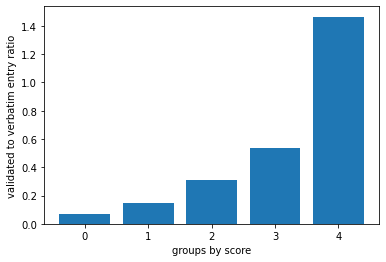

In [28]:
plt.bar(range(len(val_to_vbm_ratios)), list(val_to_vbm_ratios.values()), align='center')
plt.xlabel("groups by score")
plt.ylabel("validated to verbatim entry ratio")
plt.show()